# 语义分割———Unet

In [2]:
!pip install git+https://github.com/lyhue1991/torchkeras

  Cloning https://github.com/lyhue1991/torchkeras to /tmp/pip-req-build-w4n3813y
  Running command git clone --filter=blob:none --quiet https://github.com/lyhue1991/torchkeras /tmp/pip-req-build-w4n3813y
  Resolved https://github.com/lyhue1991/torchkeras to commit 633957eb0049e39b9b8bf6c5ccc73496e226f678
  Preparing metadata (setup.py) ... done
  Created wheel for torchkeras: filename=torchkeras-3.8.0-py3-none-any.whl size=10328187 sha256=d767b94c3e8590d0efb7eb9a73b79fe10d19ecdd93878ccedc325be9066d241a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ismbke2o/wheels/6d/b1/55/322020c14a336be6cf7bb72f3e03d3f1d854fafa2c20e8c276
Successfully built torchkeras


In [3]:
import torchkeras 
from torchkeras import models 

In [24]:
from argparse import Namespace

config = Namespace(
    img_size = 128, 
    lr = 1e-4,
    batch_size = 4,
)

## 一，准备数据

In [25]:
import torch 
import shutil
from pathlib import Path
import os 
data_url = 'https://github.com/lyhue1991/torchkeras/releases/download/v3.7.2/lane_lines.zip'
data_file = 'lane_lines.zip'

if not os.path.exists(data_file):
    torch.hub.download_url_to_file(data_url,data_file)
    shutil.unpack_archive(data_file,'datasets')

train_imgs = [str(x) for x in Path('./datasets/lane_lines/train').rglob("*.jpg") 
               if 'checkpoint' not in str(x)]

val_imgs = [str(x) for x in Path('./datasets/lane_lines/val').rglob("*.jpg") 
               if 'checkpoint' not in str(x)]



In [26]:
from pathlib import Path
from PIL import Image
import numpy as np 
import torch 
from torch import nn 
from torch.utils.data import Dataset,DataLoader 
import os 
from torchkeras.data import resize_and_pad_image 
from torchkeras.plots import joint_imgs_col 

class MyDataset(Dataset):
    def __init__(self, img_files, img_size, transforms = None):
        self.__dict__.update(locals())
        
    def __len__(self) -> int:
        return len(self.img_files)

    def get(self, index):
        img_path = self.img_files[index]
        mask_path = img_path.replace('images','masks').replace('.jpg','.png')
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        return image, mask
    
    def __getitem__(self, index):
        
        image,mask = self.get(index)
        
        image = resize_and_pad_image(image,self.img_size,self.img_size)
        mask = resize_and_pad_image(mask,self.img_size,self.img_size)
        
        image_arr = np.array(image, dtype=np.float32)/255.0
        
        mask_arr = np.array(mask,dtype=np.float32)
        mask_arr = np.where(mask_arr>100.0,1.0,0.0).astype(np.int64)
        

        sample = {
            "image": image_arr,
            "mask": mask_arr
        }
        
        if self.transforms is not None:
            sample = self.transforms(**sample)
            
        sample['mask'] = sample['mask'][None,...]

            
        return sample
    
    def show_sample(self, index):
        image, mask = self.get(index)
        image_result = joint_imgs_col(image,mask)
        return image_result
    

In [27]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def get_train_transforms():
    return A.Compose(
        [
            A.OneOf([A.HorizontalFlip(p=0.5),A.VerticalFlip(p=0.5)]),
            ToTensorV2(p=1),
        ],
        p=1.0
    )

def get_val_transforms():
    return A.Compose(
        [
            ToTensorV2(p=1),
        ],
        p=1.0
    )


In [28]:
train_transforms=get_train_transforms()
val_transforms=get_val_transforms()

ds_train = MyDataset(train_imgs,img_size=config.img_size,transforms=train_transforms)
ds_val = MyDataset(val_imgs,img_size=config.img_size,transforms=val_transforms)

dl_train = DataLoader(ds_train,batch_size=config.batch_size)
dl_val = DataLoader(ds_val,batch_size=config.batch_size)


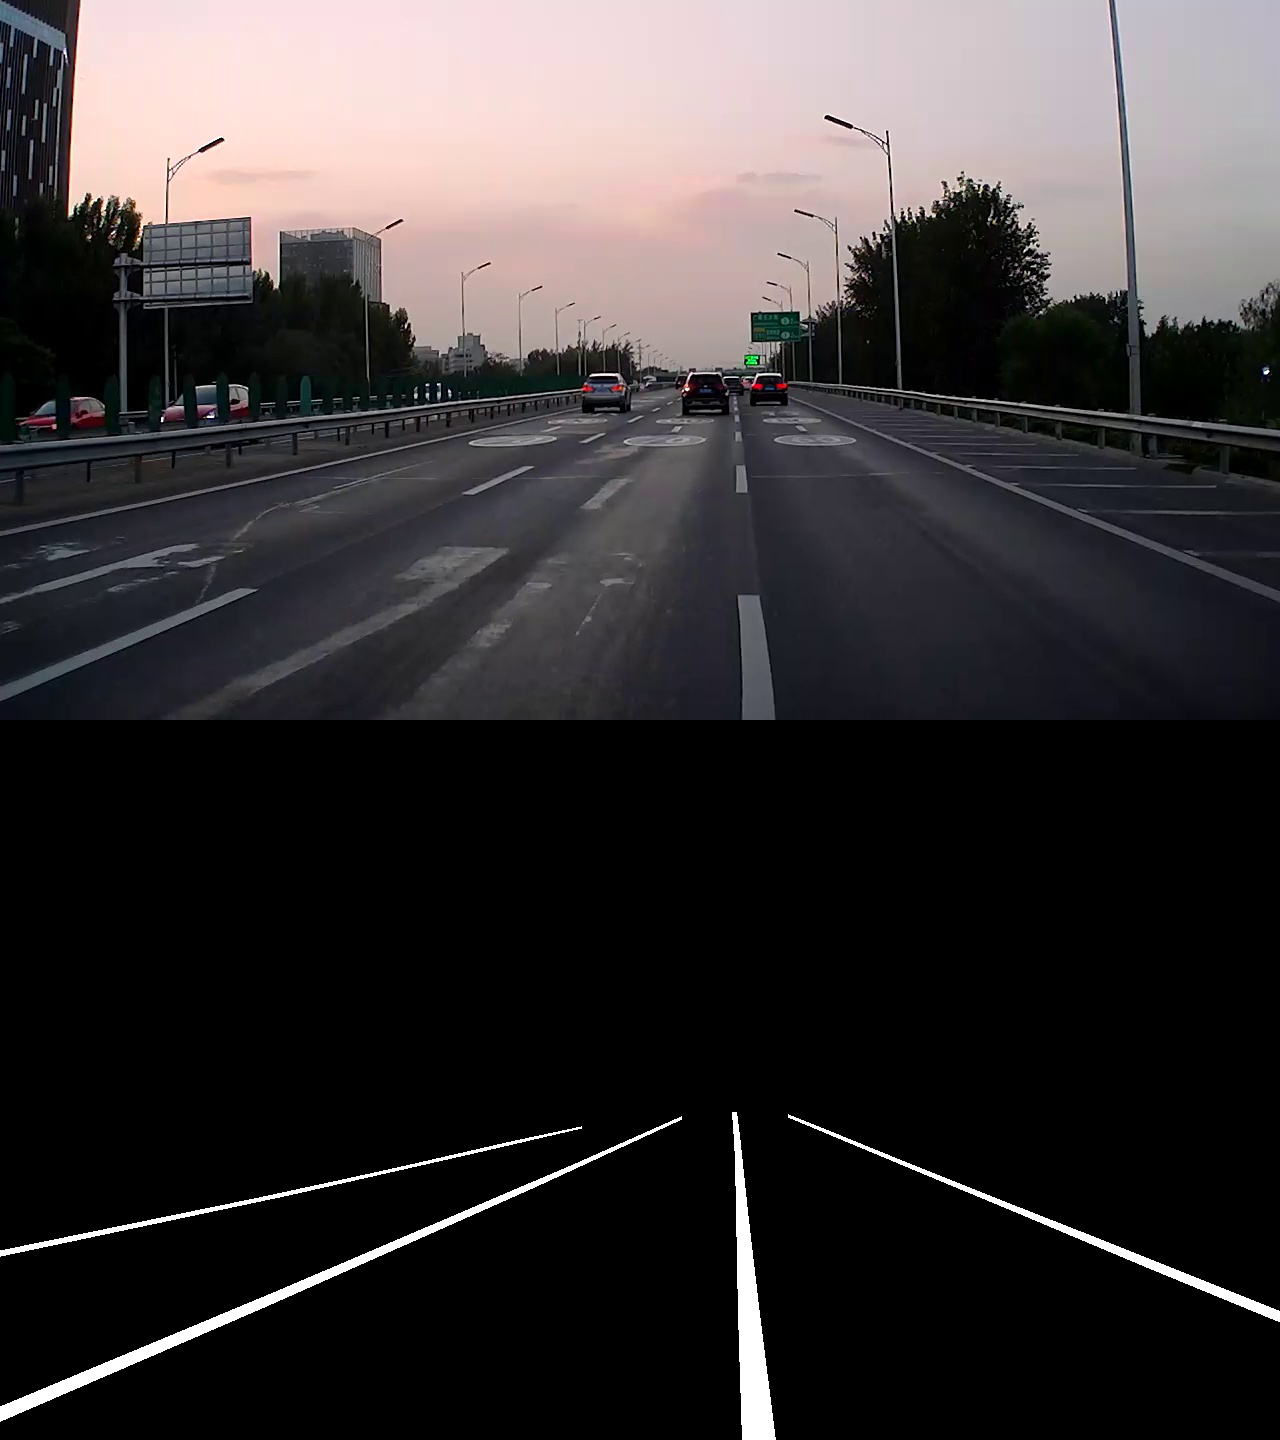

In [29]:
ds_train.show_sample(10)

In [30]:
for batch in dl_val:
    break 

In [31]:
batch['image'].shape 

torch.Size([4, 3, 128, 128])

In [32]:
batch['mask'].shape 

torch.Size([4, 1, 128, 128])

In [33]:
targets = batch['mask']

In [34]:
targets.dtype 

torch.int64

## 二，定义模型

In [35]:
from torchkeras.models import UNet 
net = UNet(in_channels=3,num_classes=1)
logits = net(batch['image'])
logits.shape

torch.Size([4, 1, 128, 128])

## 三，训练模型

In [36]:
from torchkeras import KerasModel 
from torch.nn import functional as F 

# 由于输入数据batch结构差异，需要重写StepRunner并覆盖
class StepRunner:
    def __init__(self, net, loss_fn, accelerator, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator
    
    def __call__(self, batch):
        features,labels = batch['image'],batch['mask'] 
        
        #loss
        preds = self.net(features)
        loss = self.loss_fn(preds,labels)

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_preds = self.accelerator.gather(preds)
        all_labels = self.accelerator.gather(labels)
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics
        step_metrics = {self.stage+"_"+name:metric_fn(all_preds, all_labels).item() 
                        for name,metric_fn in self.metrics_dict.items()}
        
        if self.optimizer is not None and self.stage=="train":
            step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            
        return step_losses,step_metrics


KerasModel.StepRunner = StepRunner 



In [37]:
from torchkeras.metrics import IOU


class DiceLoss(nn.Module):
    def __init__(self,smooth=0.001,num_classes=1,weights = None):
        super().__init__()
        self.smooth = smooth
        self.num_classes = num_classes
        self.weights = weights

    def forward(self, logits, targets):
        
        # binary
        if self.num_classes==1:
            preds = logits.contiguous().view(logits.size()[0], -1).sigmoid()
            targets = targets.contiguous().view(targets.size()[0], -1).float()
            loss = self.compute_loss(preds,targets)
            return loss
        
        # multiclass
        else:
            preds = logits.softmax(axis=1).contiguous().view(
                logits.size()[0],self.num_classes, -1)
            t = targets.contiguous().view(
                targets.size()[0], -1)
            targets = torch.nn.functional.one_hot(t,self.num_classes).permute(0,2,1)
            totalLoss = 0.0
            for i in range(self.num_classes):
                diceLoss = self.compute_loss(preds[:, i], targets[:, i])
                if self.weights is not None:
                    diceLoss *= self.weights[i]
                totalLoss += diceLoss
            return totalLoss
        
    def compute_loss(self,preds,targets):
        a = torch.sum(preds * targets, 1) # |X⋂Y|
        b = torch.sum(preds * preds, 1) + self.smooth  # |X|
        c = torch.sum(targets * targets, 1) + self.smooth  # |Y|
        score = (2 * a) / (b + c)
        loss = torch.mean(1-score)
        return loss
    
    
class MixedLoss(nn.Module):
    def __init__(self,bce_ratio=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.bce_ratio = bce_ratio
        
    def forward(self,logits,targets):
        bce_loss = self.bce(logits,targets.float())
        dice_loss = self.dice(logits,targets)
        total_loss = bce_loss*self.bce_ratio + dice_loss*(1-self.bce_ratio)
        return total_loss
    
    

In [38]:
optimizer = torch.optim.AdamW(net.parameters(), lr=config.lr)


lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer = optimizer,
    T_max=8,
    eta_min=0
)

metrics_dict = {'iou': IOU(num_classes=1)}

model = KerasModel(net,
                   loss_fn=MixedLoss(bce_ratio=0.5),
                   metrics_dict=metrics_dict,
                   optimizer=optimizer,
                   lr_scheduler = lr_scheduler
                  )


wandb: Currently logged in as: lyhue1991. Use `wandb login --relogin` to force relogin


<<<<<< ⚡️ cuda is used >>>>>>


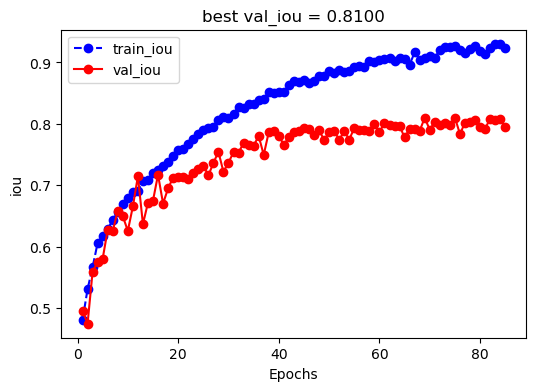

epoch,train_loss,train_iou,lr,val_loss,val_iou
1.0,0.7317520886659622,0.48057353496551514,5.000000000000009e-05,0.7835346698760987,0.4957076907157898
2.0,0.6893485933542252,0.5308007001876831,0.0,0.739212691783905,0.47445252537727356
3.0,0.661861914396286,0.5666311979293823,5.000000000000044e-05,0.666698443889618,0.5593849420547485
4.0,0.63856181204319,0.6060725450515747,0.00010000000000000128,0.6538743257522583,0.5746572017669678
5.0,0.6213410049676895,0.6169398427009583,4.9999999999999786e-05,0.6261719703674317,0.5804318189620972
6.0,0.6089887410402298,0.6281911730766296,0.0,0.6117487549781799,0.6273562908172607
7.0,0.5953805238008499,0.643878161907196,4.9999999999999806e-05,0.6045874357223511,0.6249930262565613
8.0,0.5863535851240158,0.6556717753410339,0.00010000000000000015,0.595018470287323,0.6586877107620239
9.0,0.5747199505567551,0.6697271466255188,5.0000000000000124e-05,0.5871086835861206,0.6494801044464111
10.0,0.5652178943157196,0.6793991327285767,0.0,0.5823835611343384,0.625697910785675



================================================================================2023-03-10 12:13:40
Epoch 1 / 100

100%|██████████████████████████████████| 5/5 [00:00<00:00,  5.44it/s, val_iou=0.496, val_loss=0.784]
<<<<<< reach best val_iou : 0.4957076907157898 >>>>>>

================================================================================2023-03-10 12:13:48
Epoch 2 / 100

100%|██████████████████████████████████| 5/5 [00:00<00:00,  5.31it/s, val_iou=0.474, val_loss=0.739]

================================================================================2023-03-10 12:13:54
Epoch 3 / 100

100%|██████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s, val_iou=0.559, val_loss=0.667]
<<<<<< reach best val_iou : 0.5593849420547485 >>>>>>

================================================================================2023-03-10 12:14:00
Epoch 4 / 100

100%|██████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s, val_iou=0.575, val_loss=0.654]
<<<<<< reach best val_io

best_val_iou,▁▂▃▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇██████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▅▅▅▅▅▅▅█▁█▁█▁▅▅▅▅▅▅▅█▁█▁█▁▅▅▅▅▅▅▅█▁█▁█▁▅
train_iou,▁▂▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████
train_loss,█▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_iou,▁▂▃▄▄▅▄▆▅▆▆▆▆▆▇▇▇▇█▇███▇▇▇████▇████▇████
val_loss,█▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
best_score,0.81
best_val_iou,0.81
epoch,85.0
lr,5e-05


In [39]:
from torchkeras.kerascallbacks import WandbCallback

wandb_cb = WandbCallback(project='unet_lane',
                         config=config.__dict__,
                         name=None,
                         save_code=True,
                         save_ckpt=True)

dfhistory=model.fit(train_data=dl_train, 
                    val_data=dl_val, 
                    epochs=100, 
                    ckpt_path='checkpoint.pt',
                    patience=10, 
                    monitor="val_iou",
                    mode="max",
                    mixed_precision='no',
                    callbacks = [wandb_cb],
                    plot = True 
                   )


## 四，验证模型

In [40]:
from torchkeras.plots import plot_metric 

In [41]:
plot_metric(dfhistory,'iou')

In [42]:
plot_metric(dfhistory,'loss')

In [43]:
model.evaluate(dl_val)

100%|███████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s, val_iou=0.81, val_loss=0.193]


{'val_loss': 0.1932246446609497, 'val_iou': 0.8099958300590515}

## 五，使用模型

In [51]:
batch = next(iter(dl_val))

with torch.no_grad():
    model.eval()
    logits = model(batch["image"].cuda())
    
pr_masks = logits.sigmoid()

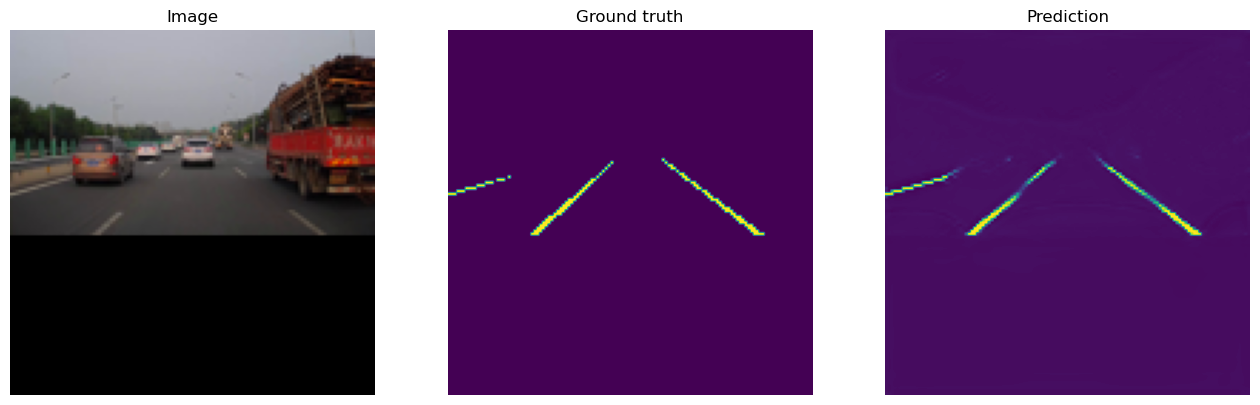

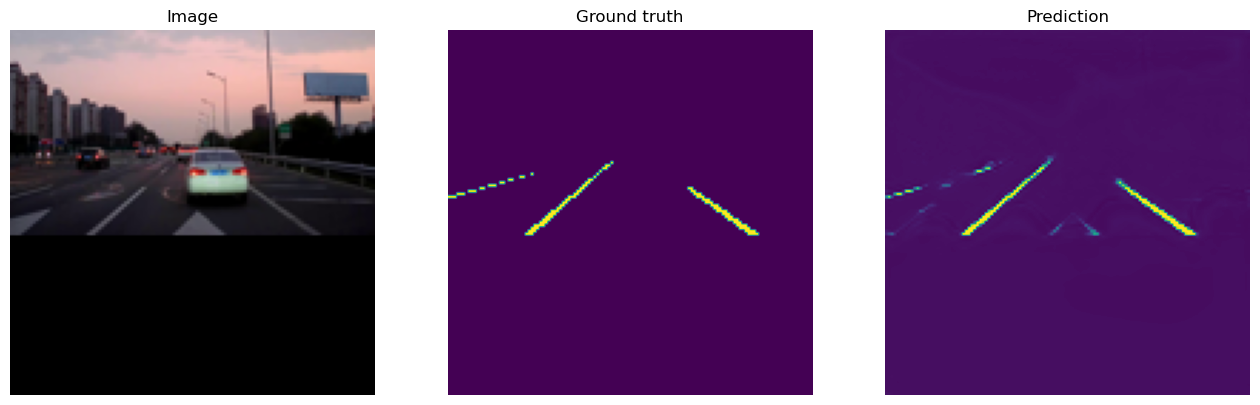

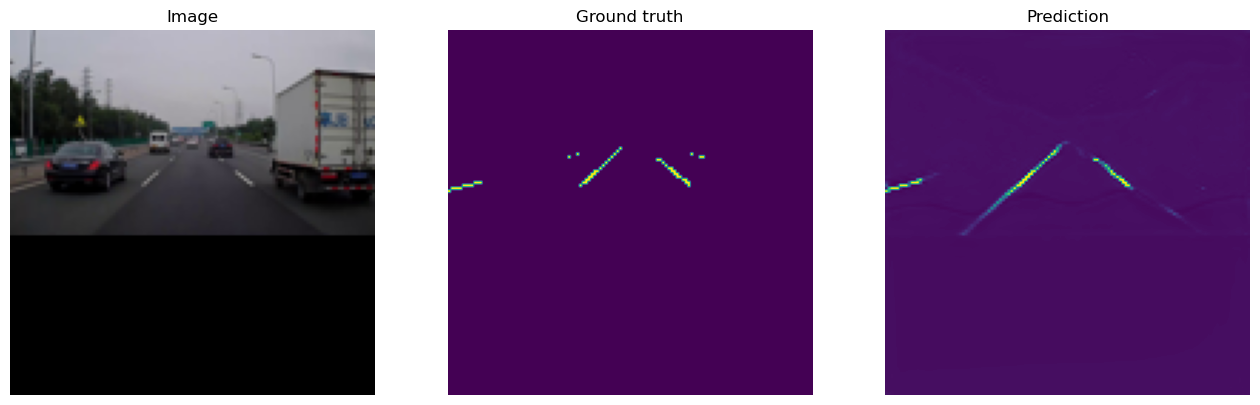

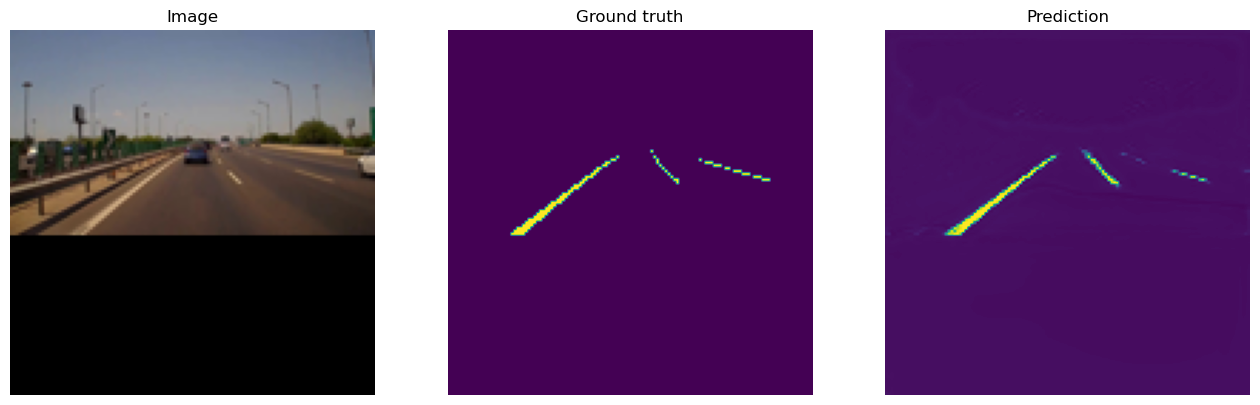

In [54]:
from matplotlib import pyplot as plt 
for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(16, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) 
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.cpu().numpy().squeeze()) 
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

## 六，保存模型

In [55]:
torch.save(net.state_dict(),'unet.ckpt')